# Fingerprint recognition

Fingerprint recognition is probably the most mature biometric technique, which finds lots of applications since long ago.
This assignment is split in two main parts: Identification and Authentication / Verification by using fingerprints. The data consists of 80 images of fingerprints that belong to 10 different individuals, which gives 8 images per person.

In [1]:
import cv2
import numpy as np
import operator
from matplotlib import pyplot as plt
from utils import *
from constants import *
from preprocessing import *
from evaluation import *

Firstly, we read the files and we prepare the dataset. Each image is converted to grayscale version and then enhancement is applied by using the following library for fingerprints enhancement in Python: https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python. The dataset is split into training and test set, with ratio 80:20. 

In [2]:
image_files = read_images()

In [3]:
train_set, test_set = prepare_dataset(image_files)

Checking the size of the training and test set. After the split of the dataset, there are 6 images per person (class) for train and 2 images for test. 

In [4]:
print('Size of the training set:', len(train_set))
print('Size of the test set:', len(test_set))

Size of the training set: 60
Size of the test set: 20


Next, we plot one image before and after converting it to grayscale and appling enhancement.

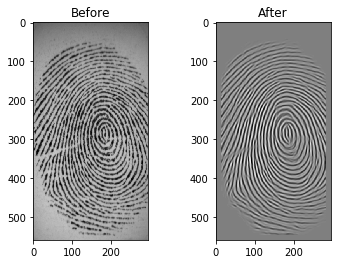

In [5]:
plt.subplot(1, 2, 1)
plt.title('Before')
img_fpr = cv2.imread(image_files[0])
plt.imshow(img_fpr, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('After')
plt.imshow(train_set['101_1.tif'], cmap='gray')
plt.show()

Next, we define few methods used afterward for the identification and authetication scenarios.

In [6]:
# Initiate ORB detector for matching keypoints
orb = cv2.ORB_create(MAX_FEATURES)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

In [7]:
# Returns feature descripors for all images from the set provided as argument
def get_feature_descriptors(dataset):
    feature_descriptors = {}
    for image_id, image in dataset.items():
        kp, des = orb.detectAndCompute(image, None)
        feature_descriptors[image_id] = des
    return feature_descriptors

In [8]:
# Returns feature distances between training features descriptors and query image
def get_features_distances(query_image, trained_features, distance_threshold): 
    matches_distance = {}
    kp1, query_des = orb.detectAndCompute(query_image, None) # features of the query image
    for train_image_id, trained_feature_des in trained_features.items():
        if query_des is not None and trained_feature_des is not None:
            matches = bf.match(query_des, trained_feature_des)
            matches.sort(key=lambda x: x.distance, reverse=False) # sort matches based on feature distance
            best_matches = [m.distance for m in matches if m.distance < distance_threshold]
            matches_distance[train_image_id] = len(best_matches) # matching function = length of best matches to given threshold
    
    matches_distance = sorted(matches_distance.items(), key = operator.itemgetter(1), reverse=True) # sort by value - feature distance
    return matches_distance

In [9]:
# Apply homography to test and train image
def apply_homography(query_image, closest_image):
    kp1, des1 = orb.detectAndCompute(query_image, None)
    kp2, des2 = orb.detectAndCompute(closest_image, None)
    matches = bf.match(des1, des2)

    # Apply homography
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # M matrix that represents the homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Use homography
    height, width = query_image.shape[:2]
    # The function warpPerspective transforms the source image using the specified matrix
    im1Reg = cv2.warpPerspective(closest_image, M, (width, height))

    # Plot aligned query and train image
    plt.subplot(1, 2, 1)
    plt.imshow(im1Reg, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(query_image, cmap='gray')
    plt.show()

In [10]:
from collections import defaultdict

def classify_fpr(feature_distances, rank):
    '''
    Counts how many fprs from the same class are there in the first ranked 
    :param feature_distances: Feature distaces from given query fpr to all training fprs
    :param rank: To take the first ranked closest features
    :return first_rank_sorted: dictionary, where key denotes the fpr class and 
            the value is how many times it appears in the first ranked fprs
    '''
    first_rank_fprs = defaultdict(int)
    for fpr_name, distance in feature_distances[0:rank]:
        fpr_class = get_image_class(fpr_name)
        first_rank_fprs[fpr_class] += 1
            
    first_rank_sorted = sorted(first_rank_fprs.items(), key = operator.itemgetter(1), reverse=True) 
    return first_rank_sorted    

In [11]:
def get_cmc_curve(x_values, y_values):
    plt.title('CMC curve')
    x_axis = np.array(x_values)
    y_axis = np.array(y_values)
    plt.plot(x_axis, y_axis) # x, y
    plt.ylim([0, 1])
    plt.xlabel('Rank')
    plt.ylabel('Probability of Recognition')
    plt.show()

In [12]:
def get_roc_curve(frr, far):
    plt.title('ROC curve')
    x_axis = np.array(far) # False Positive (Accept / Match) Rate 
    y_axis = np.array(frr) # False Reject Rate = 1 - TPR
    plt.plot(x_axis, y_axis) # x, y
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('False Reject Rate (FRR)')
    plt.xlabel('False Accept Rate (FAR)')
    plt.show()

## Identification scenario

First we analyse the identificaion scenario, which corresponds to 1:M clasification problem. Biometric identification answers the question “who are you” (used in many applications including law enforcement, defense, and border control). It is usually applied in a situation where an organization needs to identify a person. The organization captures a biometric from that individual and then searches in a database in order to correctly identify the person.

In [13]:
train_feature_descriptors = get_feature_descriptors(train_set)

In [14]:
# Definition of identification scenario
def perform_identification_scenario(dist_threshold, rank):
    true_y = []
    pred_y = []
    total_prob = 0
    print("----- START, threshold = {}, rank = {} -----".format(dist_threshold, rank))
    for test_image_id, test_image in test_set.items():
        # Get the distances between the query image and all other training images
        feature_distances = get_features_distances(test_image, train_feature_descriptors, dist_threshold)
        true_class = get_image_class(test_image_id)
                
        # Classify the first closest features according to the given rank
        first_rank_fprs = classify_fpr(feature_distances, rank)
        predicted_class = first_rank_fprs[0][0]
        prob = first_rank_fprs[0][1] / TRAIN_PER_CLASS 
        total_prob += prob
        true_y.append(1) # true_class
        if true_class != predicted_class:
            pred_y.append(0) # wrong prediction
        else:
            pred_y.append(1) # correct prediction
        
        closest_img_id = feature_distances[0][0]
        closest_img = train_set.get(closest_img_id)
#         apply_homography(test_image, closest_img)
#         print('Query fingerprint ID: ' + test_image_id)
#         print('Best matching fingerprint ID: ' + closest_img_id)

    avg_probability = total_prob/len(test_set)
    print("Averaged probability for rank %d is %f "%(rank, avg_probability))
    print("Accuracy with threshold %d is %f "%(dist_threshold, get_model_accuracy(true_y, pred_y)))
    return avg_probability


After the identification scenario method is defined, we continue with testing it. By iterating through different distance thresholds we try to find the most appropriate threshold size. 
Taking into account the size of the training set for each person, we take 3 as rank, which means that the first 3 closest fingerprints are considered when classifing the query image. This is actially similar to what kNN does, where k = 3.

In [15]:
rank = 3
for dist_threshold in range(20, 70, 10): 
    perform_identification_scenario(dist_threshold, rank)

----- START, threshold = 20, rank = 3 -----
Averaged probability for rank 3 is 0.408333 
Accuracy with threshold 20 is 0.450000 
----- START, threshold = 30, rank = 3 -----
Averaged probability for rank 3 is 0.425000 
Accuracy with threshold 30 is 0.950000 
----- START, threshold = 40, rank = 3 -----
Averaged probability for rank 3 is 0.458333 
Accuracy with threshold 40 is 0.950000 
----- START, threshold = 50, rank = 3 -----
Averaged probability for rank 3 is 0.458333 
Accuracy with threshold 50 is 1.000000 
----- START, threshold = 60, rank = 3 -----
Averaged probability for rank 3 is 0.450000 
Accuracy with threshold 60 is 0.950000 


By analyzing the obtained results, we take distance threshold = 50 for analyzing the different rankings. The accuracy of the classification is 100%, which means that every query fingerprint was correctly classified. Moreover, the probability for obtaining the matching fingerprints within rank-3 is 0,45.

In [16]:
dist_threshold = 50
avg_probabilities = []
rank_range = range(1, 15, 2) # only odd numbers as rank
for rank in rank_range:
    avg_probabilities.append(perform_identification_scenario(dist_threshold, rank))

----- START, threshold = 50, rank = 1 -----
Averaged probability for rank 1 is 0.166667 
Accuracy with threshold 50 is 1.000000 
----- START, threshold = 50, rank = 3 -----
Averaged probability for rank 3 is 0.458333 
Accuracy with threshold 50 is 1.000000 
----- START, threshold = 50, rank = 5 -----
Averaged probability for rank 5 is 0.683333 
Accuracy with threshold 50 is 0.950000 
----- START, threshold = 50, rank = 7 -----
Averaged probability for rank 7 is 0.733333 
Accuracy with threshold 50 is 0.950000 
----- START, threshold = 50, rank = 9 -----
Averaged probability for rank 9 is 0.783333 
Accuracy with threshold 50 is 0.950000 
----- START, threshold = 50, rank = 11 -----
Averaged probability for rank 11 is 0.825000 
Accuracy with threshold 50 is 0.950000 
----- START, threshold = 50, rank = 13 -----
Averaged probability for rank 13 is 0.866667 
Accuracy with threshold 50 is 0.950000 


Highest accuracy is obtained with ranks 1 and 3, which means that usually the correct class for the query fingerprint is the same as the class of the first 1 (or first 3) closest fingerprint(s).

## CMC Curve

The CMC curve or Cumulative Matching Characteristics curve is usually used as a evaluation measure in 1:M identification systems. 
The x-axis denotes the k-th rank and the y-axis denotes the probability that the query fingerprint will be contained in the top-k ranked fingerprints. From the obtained curve, it can be noticed that as the rank increases, the probability that a query image will be contained in thaat subset also increases.

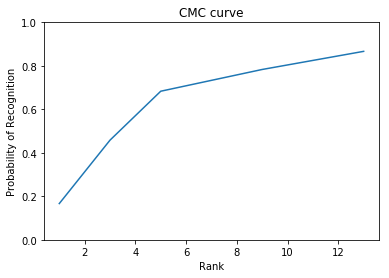

In [17]:
get_cmc_curve(rank_range, avg_probabilities)

## Authentication scenario

Second, we analyse the authentication scenario, which corresponds to 1:1 problem or binary classification. Biometric authentication asks the question “can you prove who you are”. A system will challenge someone to prove their identity and the person has to respond in order to allow them access to a system or service. For example, a person touches their finger on a sensor embedded in a smart mobile device, used by the authentication solution as part of a challenge/response system. Is it my finger? Yes, then my smartphone is unlocked, or No it isn’t my finger and the smartphone remains locked.

For the authentication scenairo, the data structure for training is slightly different, whereas the test set remains the same. For the training set, the already computed features are divided in separate dictionaries where the key denotes the class (person), and then every image features for the correspoding class are set in the dictionary as a value.

In [18]:
authentication_databases = prepare_dataset_authentication(train_feature_descriptors)

In [19]:
print('Keys of the training set = {}'.format(authentication_databases.keys()))

Keys of the training set = dict_keys(['101', '102', '103', '104', '105', '106', '107', '108', '109', '110'])


In [20]:
def count_same_fprs(feature_distances, len_best_matches):
    '''
    Counts how many fprs are close to the query fpr
    :param feature_distances: Feature distaces from given query fpr to all training fprs
    :param len_best_matches: Predefined value for the length of best features
    :return count_same: number of same fprs paris within the given len_best_matches
    '''
    count_same = 0
    for features in feature_distances:
        if int(features[1]) > len_best_matches: # Compare the len of best features for the given feature with the predefined len
            count_same += 1
            
    return count_same

In [25]:
def perform_authentication_scenario(dist_threshold, len_best_matches):
    tp = fp = fn = tn = 0
    for authentication_db_key in authentication_databases.keys():
        authentication_db = authentication_databases[authentication_db_key]
        print("----- START, Threshold = {}, Class = {} -----".format(dist_threshold, authentication_db_key))

        for test_image_id, test_image in test_set.items():    
            feature_distances = get_features_distances(test_image, authentication_db, dist_threshold) # feature distances between the query fpr and the training fprs
            count_same = count_same_fprs(feature_distances, len_best_matches)
            genuine_ratio = count_same/len(authentication_db.keys())
            test_image_class = get_image_class(test_image_id)
            
            if genuine_ratio >= 0.5: 
                if authentication_db_key == test_image_class:
                    tp += 1
                elif authentication_db_key != test_image_class:
                    fp += 1
            else:
                if authentication_db_key == test_image_class:
                    fn += 1
                elif authentication_db_key != test_image_class:
                    tn += 1
                    
            print('--- For query image: {} ---'.format(test_image_id))
            print('Probability of correct fpr = {}'.format(genuine_ratio))
    
    print('OVERALL Confusion matrix: tp = {}, fp = {}, fn = {}, tn = {}'.format(tp, fp, fn, tn))        
    true_pos_rate, false_pos_rate = calculate_ratios(tp, fp, fn, tn)
    return true_pos_rate, false_pos_rate

Before iterating through different thershold values and length of best matches, we show an example for authenticating one query fingerprint against all fprs databases.

In [26]:
# Example 
test_image_id = list(test_set)[0]
authentication_db = authentication_databases['101']
feature_distances = get_features_distances(test_set[test_image_id], authentication_db , 50) 
count_same = count_same_fprs(feature_distances, 10)
genuine_ratio = count_same/len(authentication_db.keys())
print('--- For query image: {} ---'.format(test_image_id))
print('Probability of correct fpr for class 101 = {}'.format(genuine_ratio))

--- For query image: 101_2.tif ---
Probability of correct fpr for class 101 = 0.8333333333333334


We can notice that there are ~ 83% chances that the person will be correctly identified.

In the following code section, we iterate through different threshold values and we accumulate the TPR and FPR for each threshold.

In [27]:
false_accept_rates = []
false_reject_rates = []
len_best_matches = 15
for dist_threshold in range(30, 70, 5): 
    true_pos_rate, false_pos_rate = perform_authentication_scenario(dist_threshold, len_best_matches)
    false_reject_rates.append(1-true_pos_rate)
    false_accept_rates.append(false_pos_rate)

----- START, Threshold = 30, Class = 101 -----
--- For query image: 101_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 101_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 102_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 102_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 103_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 103_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 104_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 104_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 105_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 105_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 106_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 106_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 107_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 107_6.tif ---
Probability of correct fpr = 0.0
-

--- For query image: 103_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 103_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 104_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 104_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 105_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 105_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 106_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 106_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 107_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 107_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 108_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 108_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 109_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 109_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 110_2.tif ---
Probability o

--- For query image: 104_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 104_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 105_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 105_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 106_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 106_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 107_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 107_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 108_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 108_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 109_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 109_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 110_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 110_6.tif ---
Probability of correct fpr = 0.0
----- START, Threshold = 35, Class = 104 -----
-

--- For query image: 102_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 103_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 103_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 104_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 104_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 105_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 105_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 106_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 106_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 107_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 107_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 108_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 108_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 109_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 109_6.tif ---
Probability o

--- For query image: 110_6.tif ---
Probability of correct fpr = 0.0
----- START, Threshold = 40, Class = 105 -----
--- For query image: 101_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 101_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 102_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 102_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 103_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 103_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 104_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 104_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 105_2.tif ---
Probability of correct fpr = 0.3333333333333333
--- For query image: 105_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 106_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 106_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 107_2.tif ---
Probability of corr

--- For query image: 108_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 109_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 109_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 110_2.tif ---
Probability of correct fpr = 0.16666666666666666
--- For query image: 110_6.tif ---
Probability of correct fpr = 0.0
OVERALL Confusion matrix: tp = 4, fp = 0, fn = 16, tn = 180
----- START, Threshold = 45, Class = 101 -----
--- For query image: 101_2.tif ---
Probability of correct fpr = 0.3333333333333333
--- For query image: 101_6.tif ---
Probability of correct fpr = 0.3333333333333333
--- For query image: 102_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 102_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 103_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 103_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 104_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 104_6.tif 

--- For query image: 106_2.tif ---
Probability of correct fpr = 0.8333333333333334
--- For query image: 106_6.tif ---
Probability of correct fpr = 0.8333333333333334
--- For query image: 107_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 107_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 108_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 108_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 109_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 109_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 110_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 110_6.tif ---
Probability of correct fpr = 0.0
----- START, Threshold = 45, Class = 107 -----
--- For query image: 101_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 101_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 102_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 102_6.tif ---
Prob

--- For query image: 105_6.tif ---
Probability of correct fpr = 0.5
--- For query image: 106_2.tif ---
Probability of correct fpr = 0.3333333333333333
--- For query image: 106_6.tif ---
Probability of correct fpr = 0.3333333333333333
--- For query image: 107_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 107_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 108_2.tif ---
Probability of correct fpr = 0.16666666666666666
--- For query image: 108_6.tif ---
Probability of correct fpr = 0.3333333333333333
--- For query image: 109_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 109_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 110_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 110_6.tif ---
Probability of correct fpr = 0.0
----- START, Threshold = 50, Class = 103 -----
--- For query image: 101_2.tif ---
Probability of correct fpr = 0.16666666666666666
--- For query image: 101_6.tif ---
Probability of correct fp

--- For query image: 103_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 103_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 104_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 104_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 105_2.tif ---
Probability of correct fpr = 0.16666666666666666
--- For query image: 105_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 106_2.tif ---
Probability of correct fpr = 0.16666666666666666
--- For query image: 106_6.tif ---
Probability of correct fpr = 0.6666666666666666
--- For query image: 107_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 107_6.tif ---
Probability of correct fpr = 0.16666666666666666
--- For query image: 108_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 108_6.tif ---
Probability of correct fpr = 0.8333333333333334
--- For query image: 109_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 109_6.tif ---
Pro

--- For query image: 107_6.tif ---
Probability of correct fpr = 0.5
--- For query image: 108_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 108_6.tif ---
Probability of correct fpr = 1.0
--- For query image: 109_2.tif ---
Probability of correct fpr = 0.16666666666666666
--- For query image: 109_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 110_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 110_6.tif ---
Probability of correct fpr = 0.0
----- START, Threshold = 55, Class = 104 -----
--- For query image: 101_2.tif ---
Probability of correct fpr = 0.5
--- For query image: 101_6.tif ---
Probability of correct fpr = 0.6666666666666666
--- For query image: 102_2.tif ---
Probability of correct fpr = 0.5
--- For query image: 102_6.tif ---
Probability of correct fpr = 0.6666666666666666
--- For query image: 103_2.tif ---
Probability of correct fpr = 0.6666666666666666
--- For query image: 103_6.tif ---
Probability of correct fpr = 0.1666666666

--- For query image: 103_6.tif ---
Probability of correct fpr = 0.6666666666666666
--- For query image: 104_2.tif ---
Probability of correct fpr = 0.5
--- For query image: 104_6.tif ---
Probability of correct fpr = 0.6666666666666666
--- For query image: 105_2.tif ---
Probability of correct fpr = 0.8333333333333334
--- For query image: 105_6.tif ---
Probability of correct fpr = 0.6666666666666666
--- For query image: 106_2.tif ---
Probability of correct fpr = 0.5
--- For query image: 106_6.tif ---
Probability of correct fpr = 0.5
--- For query image: 107_2.tif ---
Probability of correct fpr = 0.0
--- For query image: 107_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 108_2.tif ---
Probability of correct fpr = 0.16666666666666666
--- For query image: 108_6.tif ---
Probability of correct fpr = 0.8333333333333334
--- For query image: 109_2.tif ---
Probability of correct fpr = 0.8333333333333334
--- For query image: 109_6.tif ---
Probability of correct fpr = 0.166666666666

--- For query image: 109_6.tif ---
Probability of correct fpr = 0.16666666666666666
--- For query image: 110_2.tif ---
Probability of correct fpr = 0.5
--- For query image: 110_6.tif ---
Probability of correct fpr = 0.0
----- START, Threshold = 60, Class = 105 -----
--- For query image: 101_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 101_6.tif ---
Probability of correct fpr = 1.0
--- For query image: 102_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 102_6.tif ---
Probability of correct fpr = 1.0
--- For query image: 103_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 103_6.tif ---
Probability of correct fpr = 1.0
--- For query image: 104_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 104_6.tif ---
Probability of correct fpr = 1.0
--- For query image: 105_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 105_6.tif ---
Probability of correct fpr = 1.0
--- For query image: 106_2.tif ---
Probability of cor

--- For query image: 108_2.tif ---
Probability of correct fpr = 0.6666666666666666
--- For query image: 108_6.tif ---
Probability of correct fpr = 0.8333333333333334
--- For query image: 109_2.tif ---
Probability of correct fpr = 0.5
--- For query image: 109_6.tif ---
Probability of correct fpr = 0.0
--- For query image: 110_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 110_6.tif ---
Probability of correct fpr = 0.16666666666666666
OVERALL Confusion matrix: tp = 18, fp = 161, fn = 2, tn = 19
----- START, Threshold = 65, Class = 101 -----
--- For query image: 101_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 101_6.tif ---
Probability of correct fpr = 1.0
--- For query image: 102_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 102_6.tif ---
Probability of correct fpr = 1.0
--- For query image: 103_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 103_6.tif ---
Probability of correct fpr = 1.0
--- For query image: 104_2.tif

--- For query image: 106_6.tif ---
Probability of correct fpr = 1.0
--- For query image: 107_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 107_6.tif ---
Probability of correct fpr = 1.0
--- For query image: 108_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 108_6.tif ---
Probability of correct fpr = 1.0
--- For query image: 109_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 109_6.tif ---
Probability of correct fpr = 1.0
--- For query image: 110_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 110_6.tif ---
Probability of correct fpr = 1.0
----- START, Threshold = 65, Class = 107 -----
--- For query image: 101_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 101_6.tif ---
Probability of correct fpr = 1.0
--- For query image: 102_2.tif ---
Probability of correct fpr = 1.0
--- For query image: 102_6.tif ---
Probability of correct fpr = 1.0
--- For query image: 103_2.tif ---
Probability of correct fpr = 1.0
-

In [28]:
print(false_reject_rates)
print(false_accept_rates)

[0.95, 0.95, 0.8, 0.4, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.6666666666666666, 0.8944444444444445, 1.0]


The evaluation of 1:1 biometric authentication systems is usually done by estimating False Accept Rate (FAR) and False Reject Rate (FRR). Using these estimates, a ROC curve is generated. [1] Compared to the standard ROC curve, where we plot the True Positive Rate (TPR) against the False Positive Rate (FAR), in the domain of biometric sytems, instead of TPR, we plot FRR (or 1 - TPR).

### ROC curve  (FAR vs FRR)

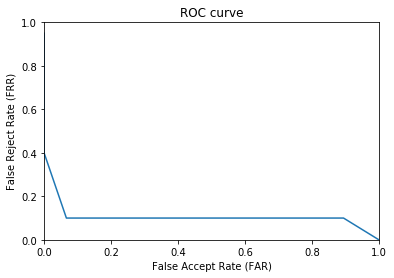

In [29]:
get_roc_curve(false_reject_rates, false_accept_rates)

## References:

[1] R. M. Bolle, J. H. Connell, S. Pankanti, N. K. Ratha and A. W. Senior, "The relation between the ROC curve and the CMC," Fourth IEEE Workshop on Automatic Identification Advanced Technologies (AutoID'05), Buffalo, NY, USA, 2005, pp. 15-20.